<a href="https://colab.research.google.com/github/Ashishpathak78/ML_-Practice/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preprocessing**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)



**Question 1: Comparing Single vs Ensemble Classifiers**

In [ ]:
# ==============================================
# 1. Comparing Single vs Ensemble Classifiers
# ==============================================

# Import required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# ----- Train and Evaluate Decision Tree -----
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Evaluation Metrics for Decision Tree
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_prec = precision_score(y_test, y_pred_dt)
dt_rec = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

# ----- Train and Evaluate Random Forest -----
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics for Random Forest
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

# ----- Display Comparison -----
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest (100 trees)'],
    'Accuracy': [dt_acc, rf_acc],
    'Precision': [dt_prec, rf_prec],
    'Recall': [dt_rec, rf_rec],
    'F1-Score': [dt_f1, rf_f1]
})

print("Model Performance Comparison:\n")
print(results)

# ----- Explore Effect of Changing Number of Estimators -----
n_estimators_list = [10, 50, 100, 200, 300]
rf_metrics = []

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rf_metrics.append([
        n,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ])

rf_df = pd.DataFrame(rf_metrics, columns=['n_estimators', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
print("\nEffect of Increasing Number of Estimators in Random Forest:\n")
print(rf_df)

# ----- Observations -----
# - Random Forest generally outperforms Decision Tree in all metrics.
# - Increasing the number of estimators improves stability and reduces variance.
# - After a certain point, performance gain becomes minimal.


Model Performance Comparison:

                       Model  Accuracy  Precision  Recall  F1-Score
0              Decision Tree  0.701299   0.555556  0.6875  0.614525
1  Random Forest (100 trees)  0.757576   0.646341  0.6625  0.654321

Effect of Increasing Number of Estimators in Random Forest:

   n_estimators  Accuracy  Precision  Recall  F1-Score
0            10  0.735931   0.623377  0.6000  0.611465
1            50  0.740260   0.616279  0.6625  0.638554
2           100  0.757576   0.646341  0.6625  0.654321
3           200  0.757576   0.650000  0.6500  0.650000
4           300  0.753247   0.641975  0.6500  0.645963


**Implementing Simple Ensemble Techniques — Max Voting, Average Voting, and Weighted Voting**

In [ ]:
# ==============================================
# 2. Implementing Simple Ensemble Techniques
# ==============================================

# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# ----- Define Base Classifiers -----
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = RandomForestClassifier(n_estimators=100, random_state=42)

models = [clf1, clf2, clf3]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']

# ----- Train Each Model -----
for model in models:
    model.fit(X_train, y_train)

# ----- Get Predictions -----
preds = np.array([model.predict(X_test) for model in models])

# ==============================================
# Max Voting Ensemble
# ==============================================
from scipy.stats import mode
max_voting_preds = mode(preds, axis=0).mode

# ==============================================
# Average Voting (using predicted probabilities)
# ==============================================
probs = np.array([model.predict_proba(X_test)[:,1] for model in models])
avg_probs = np.mean(probs, axis=0)
avg_voting_preds = (avg_probs >= 0.5).astype(int)

# ==============================================
# Weighted Average Voting
# (assign weights based on each model's individual F1-score)
# ==============================================
weights = []
for model in models:
    pred = model.predict(X_test)
    weights.append(f1_score(y_test, pred))
weights = np.array(weights)
weighted_probs = np.average(probs, axis=0, weights=weights)
weighted_voting_preds = (weighted_probs >= 0.5).astype(int)

# ==============================================
# Evaluate All Methods
# ==============================================
def evaluate(y_true, y_pred, method_name):
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

results = []
results.append(evaluate(y_test, max_voting_preds, 'Max Voting'))
results.append(evaluate(y_test, avg_voting_preds, 'Average Voting'))
results.append(evaluate(y_test, weighted_voting_preds, 'Weighted Average Voting'))

# Add individual model performances for reference
for i, model in enumerate(models):
    pred = model.predict(X_test)
    results.append(evaluate(y_test, pred, model_names[i]))

# Display Results
results_df = pd.DataFrame(results)
print("\nModel and Ensemble Performance Comparison:\n")
print(results_df)



Model and Ensemble Performance Comparison:

                    Method  Accuracy  Precision  Recall  F1-Score
0               Max Voting  0.748918   0.630952  0.6625  0.646341
1           Average Voting  0.735931   0.602151  0.7000  0.647399
2  Weighted Average Voting  0.735931   0.602151  0.7000  0.647399
3      Logistic Regression  0.735931   0.617284  0.6250  0.621118
4            Decision Tree  0.701299   0.555556  0.6875  0.614525
5            Random Forest  0.757576   0.646341  0.6625  0.654321


**Question 3: Hard Voting vs Soft Voting Classifiers**

In [ ]:
# ==============================================
# 3. Hard Voting vs Soft Voting Classifiers
# ==============================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# ----- Define Base Learners -----
log_clf = LogisticRegression(max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()

# ----- Hard Voting Classifier -----
hard_voting = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('knn', knn_clf)],
    voting='hard'
)

# ----- Soft Voting Classifier -----
soft_voting = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', dt_clf), ('knn', knn_clf)],
    voting='soft'
)

# ----- Train and Evaluate -----
hard_voting.fit(X_train, y_train)
soft_voting.fit(X_train, y_train)

y_pred_hard = hard_voting.predict(X_test)
y_pred_soft = soft_voting.predict(X_test)

# ----- Compare Performance -----
comparison = pd.DataFrame({
    'Model': ['Hard Voting', 'Soft Voting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_hard),
        accuracy_score(y_test, y_pred_soft)
    ],
    'Precision': [
        precision_score(y_test, y_pred_hard),
        precision_score(y_test, y_pred_soft)
    ],
    'Recall': [
        recall_score(y_test, y_pred_hard),
        recall_score(y_test, y_pred_soft)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_hard),
        f1_score(y_test, y_pred_soft)
    ]
})

print("\nPerformance Comparison: Hard vs Soft Voting\n")
print(comparison)



Performance Comparison: Hard vs Soft Voting

         Model  Accuracy  Precision  Recall  F1-Score
0  Hard Voting  0.731602   0.607143  0.6375  0.621951
1  Soft Voting  0.735931   0.606742  0.6750  0.639053


**Exploring Bagging Technique (Random Forest)**

In [ ]:
# ==============================================
# 4. Exploring Bagging Technique (Random Forest)
# ==============================================

# ----- Experimenting with Different Parameters -----
param_results = []

for n_estimators in [10, 50, 100, 200]:
    for max_depth in [None, 5, 10, 15]:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        param_results.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

# ----- Create DataFrame for Results -----
rf_results = pd.DataFrame(param_results)
print("\nRandom Forest Performance for Different Parameters:\n")
print(rf_results)



Random Forest Performance for Different Parameters:

    n_estimators  max_depth  Accuracy  Precision  Recall  F1-Score
0             10        NaN  0.735931   0.623377  0.6000  0.611465
1             10        5.0  0.753247   0.661972  0.5875  0.622517
2             10       10.0  0.731602   0.597826  0.6875  0.639535
3             10       15.0  0.753247   0.649351  0.6250  0.636943
4             50        NaN  0.740260   0.616279  0.6625  0.638554
5             50        5.0  0.744589   0.647887  0.5750  0.609272
6             50       10.0  0.735931   0.614458  0.6375  0.625767
7             50       15.0  0.740260   0.619048  0.6500  0.634146
8            100        NaN  0.757576   0.646341  0.6625  0.654321
9            100        5.0  0.753247   0.661972  0.5875  0.622517
10           100       10.0  0.744589   0.629630  0.6375  0.633540
11           100       15.0  0.744589   0.623529  0.6625  0.642424
12           200        NaN  0.757576   0.650000  0.6500  0.650000
13      

**Question 5: Using RandomForestRegressor and OOB Score**

In [ ]:
# ==============================================
# 5. Using RandomForestRegressor and OOB Score
# ==============================================

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# ----- Load Regression Dataset -----
data = fetch_california_housing()
X, y = data.data, data.target

# ----- Split Data -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ----- Explore OOB Score with Different n_estimators -----
results = []

for n in [10, 50, 100, 200, 300]:
    rf_reg = RandomForestRegressor(
        n_estimators=n,
        oob_score=True,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    rf_reg.fit(X_train, y_train)

    y_pred = rf_reg.predict(X_test)
    results.append({
        'n_estimators': n,
        'OOB Score': rf_reg.oob_score_,
        'R2 Score (Test)': r2_score(y_test, y_pred),
        'RMSE (Test)': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# ----- Display Results -----
rf_oob_results = pd.DataFrame(results)
print("\nRandomForestRegressor Performance with OOB Scores:\n")
print(rf_oob_results)


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(



RandomForestRegressor Performance with OOB Scores:

   n_estimators  OOB Score  R2 Score (Test)  RMSE (Test)
0            10   0.683727         0.782926     0.533777
1            50   0.794070         0.803644     0.507666
2           100   0.800922         0.804573     0.506463
3           200   0.805441         0.806819     0.503545
4           300   0.805884         0.807929     0.502097


**Question 6: Exploring Boosting Techniques**

In [ ]:
# ==============================================
# 6. Exploring Boosting Techniques
# ==============================================

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
import pandas as pd

# ----- Helper Function for Evaluation -----
def evaluate_clf(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

# ==============================================
# A. Adaptive Boosting (AdaBoost)
# ==============================================
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)
ada.fit(X_train, y_train)
ada_result = evaluate_clf(ada, X_test, y_test, 'AdaBoost')

# ==============================================
# B. Gradient Boosting (Classification)
# ==============================================
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)
gb_clf_result = evaluate_clf(gb_clf, X_test, y_test, 'Gradient Boosting (Classifier)')

# ==============================================
# C. Gradient Boosting (Regression Example)
# ==============================================
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

Xr, yr = fetch_california_housing(return_X_y=True)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3, random_state=42)

gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
gb_reg.fit(Xr_train, yr_train)
yr_pred = gb_reg.predict(Xr_test)
gb_reg_result = {
    'Model': 'Gradient Boosting (Regressor)',
    'R2 Score': r2_score(yr_test, yr_pred)
}

# ==============================================
# D. XGBoost (Extreme Gradient Boosting)
# ==============================================
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_result = evaluate_clf(xgb, X_test, y_test, 'XGBoost')

# ==============================================
# E. CatBoost
# ==============================================
cat = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=4, verbose=0, random_state=42)
cat.fit(X_train, y_train)
cat_result = evaluate_clf(cat, X_test, y_test, 'CatBoost')

# ==============================================
# Combine and Display Results
# ==============================================
results_df = pd.DataFrame([ada_result, gb_clf_result, xgb_result, cat_result])
print("\nBoosting Techniques - Classification Performance Comparison:\n")
print(results_df)

print("\nGradient Boosting Regressor Performance:\n")
print(pd.DataFrame([gb_reg_result]))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Boosting Techniques - Classification Performance Comparison:

                            Model  Accuracy  Precision  Recall  F1-Score
0                        AdaBoost  0.766234   0.671053  0.6375  0.653846
1  Gradient Boosting (Classifier)  0.748918   0.630952  0.6625  0.646341
2                         XGBoost  0.722944   0.590909  0.6500  0.619048
3                        CatBoost  0.731602   0.602273  0.6625  0.630952

Gradient Boosting Regressor Performance:

                           Model  R2 Score
0  Gradient Boosting (Regressor)  0.823529


**Question 8: Visualizing the Ensemble Models**

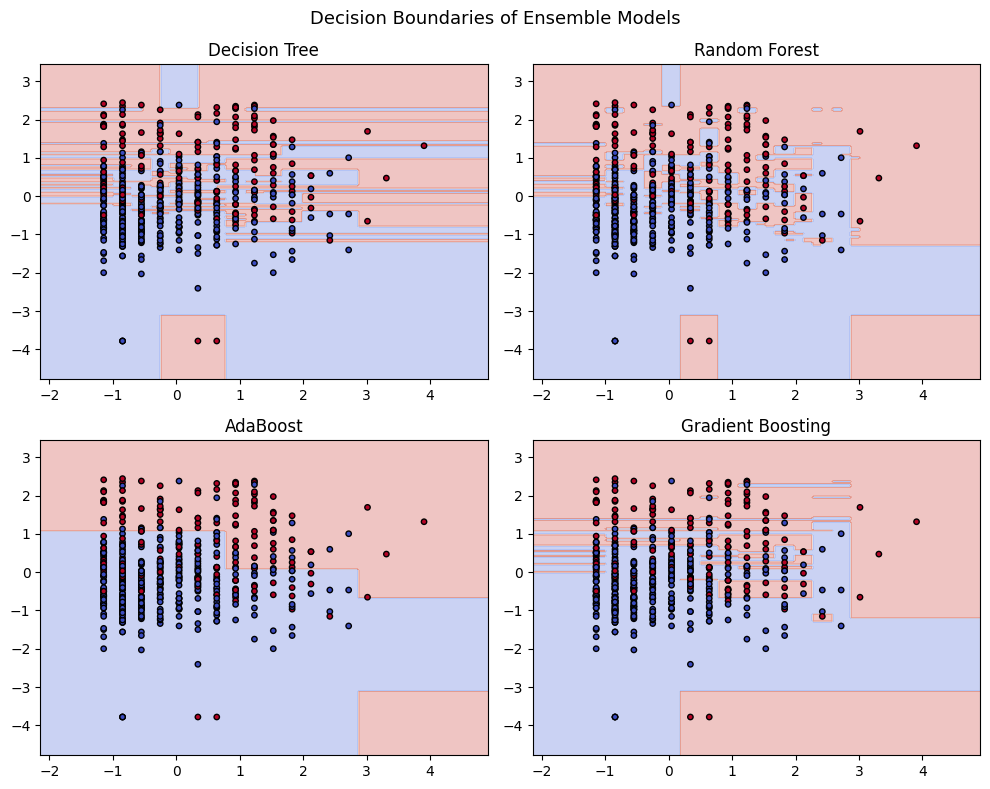


Performance Comparison under Noisy Data:

                        Model  Accuracy (Clean)  Accuracy (Noisy)
0      RandomForestClassifier          0.757576          0.740260
1          AdaBoostClassifier          0.757576          0.735931
2  GradientBoostingClassifier          0.748918          0.735931


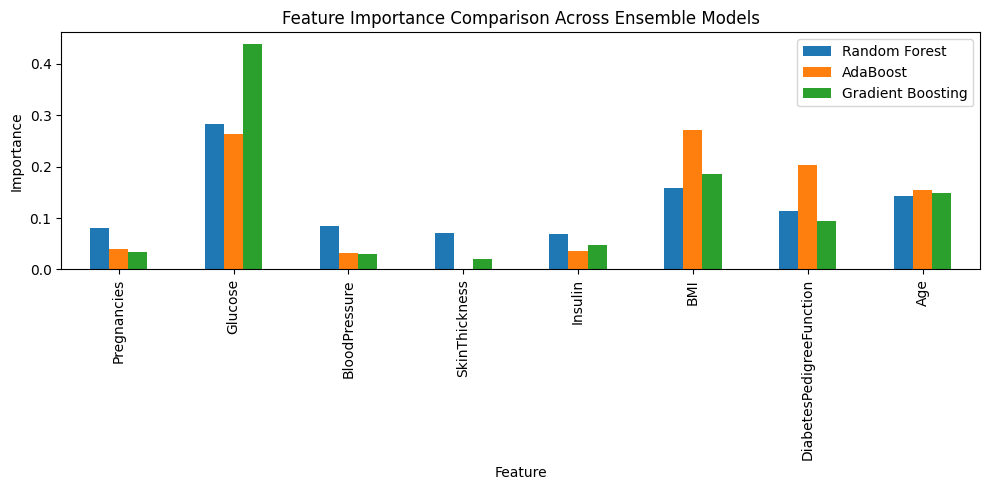

In [ ]:
# ==============================================
# 8. Visualizing Ensemble Models
# ==============================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importances

# ----- Select Two Features for 2D Visualization -----
# (to visualize decision boundaries)
X_vis = X_train[:, :2]
X_vis_test = X_test[:, :2]

dt_vis = DecisionTreeClassifier(random_state=42).fit(X_vis, y_train)
rf_vis = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_vis, y_train)
ada_vis = AdaBoostClassifier(n_estimators=100, random_state=42).fit(X_vis, y_train)
gb_vis = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(X_vis, y_train)

models_vis = {
    "Decision Tree": dt_vis,
    "Random Forest": rf_vis,
    "AdaBoost": ada_vis,
    "Gradient Boosting": gb_vis
}

# ==============================================
# A. Decision Boundary Visualization
# ==============================================
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

for ax, (name, model) in zip(axes.flatten(), models_vis.items()):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, s=15, cmap='coolwarm', edgecolor='k')
    ax.set_title(name)

plt.suptitle("Decision Boundaries of Ensemble Models", fontsize=13)
plt.tight_layout()
plt.show()

# ==============================================
# B. Performance under Noisy Data
# ==============================================
# Add random Gaussian noise to test features
X_test_noisy = X_test + np.random.normal(0, 0.3, X_test.shape)

models_eval = [RandomForestClassifier(n_estimators=100, random_state=42),
               AdaBoostClassifier(n_estimators=100, random_state=42),
               GradientBoostingClassifier(n_estimators=100, random_state=42)]

noise_results = []
for model in models_eval:
    model.fit(X_train, y_train)
    y_pred_clean = model.predict(X_test)
    y_pred_noisy = model.predict(X_test_noisy)
    noise_results.append({
        'Model': model.__class__.__name__,
        'Accuracy (Clean)': accuracy_score(y_test, y_pred_clean),
        'Accuracy (Noisy)': accuracy_score(y_test, y_pred_noisy)
    })

noise_df = pd.DataFrame(noise_results)
print("\nPerformance Comparison under Noisy Data:\n")
print(noise_df)

# ==============================================
# C. Feature Importance Comparison
# ==============================================
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
ada = AdaBoostClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

importances = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Random Forest': rf.feature_importances_,
    'AdaBoost': ada.feature_importances_,
    'Gradient Boosting': gb.feature_importances_
})

# Plot feature importance comparison
importances.set_index('Feature').plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance Comparison Across Ensemble Models")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


**Question 9: Exploring Heterogeneous Ensemble Models**

In [27]:
# ==============================================
# 9. Exploring Heterogeneous Ensemble Models
# ==============================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# ----- Define Base Learners for Heterogeneous Ensemble -----
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(probability=True, random_state=42)

# ----- Hard Voting Classifier -----
hetero_hard = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('lr', lr), ('svm', svm)],
    voting='hard'
)

# ----- Soft Voting Classifier -----
hetero_soft = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('lr', lr), ('svm', svm)],
    voting='soft'
)

# ----- Fit Models -----
hetero_hard.fit(X_train, y_train)
hetero_soft.fit(X_train, y_train)

# ----- Predictions -----
y_pred_hard = hetero_hard.predict(X_test)
y_pred_soft = hetero_soft.predict(X_test)

# ----- Evaluate Performance -----
hetero_results = pd.DataFrame({
    'Model': ['Heterogeneous (Hard Voting)', 'Heterogeneous (Soft Voting)', 'Random Forest (Homogeneous)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_hard),
        accuracy_score(y_test, y_pred_soft),
        accuracy_score(y_test, RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train).predict(X_test))
    ],
    'Precision': [
        precision_score(y_test, y_pred_hard),
        precision_score(y_test, y_pred_soft),
        precision_score(y_test, RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train).predict(X_test))
    ],
    'Recall': [
        recall_score(y_test, y_pred_hard),
        recall_score(y_test, y_pred_soft),
        recall_score(y_test, RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train).predict(X_test))
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_hard),
        f1_score(y_test, y_pred_soft),
        f1_score(y_test, RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train).predict(X_test))
    ]
})

print("\nHeterogeneous vs Homogeneous Ensemble Comparison:\n")
print(hetero_results)



Heterogeneous vs Homogeneous Ensemble Comparison:

                         Model  Accuracy  Precision  Recall  F1-Score
0  Heterogeneous (Hard Voting)  0.748918   0.644737  0.6125  0.628205
1  Heterogeneous (Soft Voting)  0.748918   0.630952  0.6625  0.646341
2  Random Forest (Homogeneous)  0.757576   0.646341  0.6625  0.654321
